<h1><b>Inf1038 - Aprendizado Automático<b></h1>
<h4><b>Grupo:</b></h4> 
 - Eduardo Luna: 2111484 <br>
 - Luca Ribeiro: 2112662 <br>
 - Lucas Larios: 2020723 <br>

In [4]:
!pip install -r requirements.txt 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.2/216.2 kB 4.5 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
  Obtaining dependency information for pandas from https://files.pythonhosted.org/packages/de/ce/b5d9c7ce1aaf9023b823c81932a50cd5e8f407198a696b0d1c6025a40b03/pandas-2.1.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for seaborn from https://files.pythonhosted.org/packages/7b/e5/83fcd7e9db036c179e0352bfcd20f81d728197a16f883e7b90307a88e65e/seaborn-0.13.0-py3-none-any.whl.metadata
  Obtaining dependency information for torch from https://files.pythonhosted.org/packages/5b/13/fcabc86948f9e89b62a538670720f8589d63f93d3f4f3d172236a98e70f8/torch-2.1.0-cp311-cp311-manylinux1_x86_64.whl.metadata
  Obtaining dependency information for lightgbm from https://files.pythonhosted.org/packages/b8/9d/1ce80cee7c5ef60f2fcc7e9fa97f29f7a8de3dc5a08922b3b2f1e9106481/lightgbm-4.1.0-py3-none-manylinux_2_28_x86_64.whl.metadata
  O

In [1]:
!pip install scikeras | grep -v 'already satisfied'

  Obtaining dependency information for scikeras from https://files.pythonhosted.org/packages/5d/fa/9c1967952e7889d698f10ba8b6af79dfaa2e05178d97a79fbd9d1b44e589/scikeras-0.12.0-py3-none-any.whl.metadata
  Obtaining dependency information for scikit-learn>=1.0.0 from https://files.pythonhosted.org/packages/0c/2a/d3ff6091406bc2207e0adb832ebd15e40ac685811c7e2e3b432bfd969b71/scikit_learn-1.3.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for scipy>=1.5.0 from https://files.pythonhosted.org/packages/ef/1b/7538792254aec6850657d5b940fd05fe60582af829ffe40d6c054f065f34/scipy-1.11.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 3.2 MB/s eta 0:00:00
  Obtaining dependency information for joblib>=1.1.1 from https://files.pythonhosted.org/packages/10/40/d551139c85db202f1f384ba8bcf96aca2f329440a844f924c8a0040b6d02/joblib-1.3.2-py3-none-any.whl.metadata
  Obtaining

In [5]:
!pip install eli5


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [5]:
# import eli5
import numpy as np
import pandas as pd
import re
import seaborn as sns
import tensorflow as tf
# from eli5.sklearn import PermutationImportance
from lightgbm import LGBMRegressor
from matplotlib import pyplot as plt
from scikeras.wrappers import KerasRegressor
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import ElasticNet, LinearRegression, Ridge
from sklearn.metrics import mean_squared_error as mse, r2_score
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.svm import SVR
from sklearn.tree import plot_tree, DecisionTreeRegressor
from tensorflow.keras import layers, callbacks
from xgboost import XGBRegressor
from yellowbrick.model_selection import ValidationCurve

2023-10-24 13:30:26.762407: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-24 13:30:26.762650: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-24 13:30:26.764327: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-24 13:30:26.923716: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
# data set https://www.kaggle.com/datasets/samanemami/renewable-energy-and-weather-conditions
df = pd.read_csv('data/solar_weather.csv', parse_dates = ['Time'])
 
display(df)

,Time,Energy delta[Wh],GHI,temp,pressure,humidity,wind_speed,rain_1h,snow_1h,clouds_all,isSun,sunlightTime,dayLength,SunlightTime/daylength,weather_type,hour,month
0,2017-01-01 00:00:00,0,0.0,1.6,1021,100,4.9,0.0,0.0,100,0,0,450,0.00,4,0,1
1,2017-01-01 00:15:00,0,0.0,1.6,1021,100,4.9,0.0,0.0,100,0,0,450,0.00,4,0,1
2,2017-01-01 00:30:00,0,0.0,1.6,1021,100,4.9,0.0,0.0,100,0,0,450,0.00,4,0,1
3,2017-01-01 00:45:00,0,0.0,1.6,1021,100,4.9,0.0,0.0,100,0,0,450,0.00,4,0,1
4,2017-01-01 01:00:00,0,0.0,1.7,1020,100,5.2,0.0,0.0,100,0,0,450,0.00,4,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196771,2022-08-31 16:45:00,118,23.7,18.6,1023,57,3.8,0.0,0.0,52,1,780,825,0.95,3,16,8
196772,2022-08-31 17:00:00,82,15.6,18.5,1023,61,4.2,0.0,0.0,60,1,795,825,0.96,3,17,8
196773,2022-08-31 17:15:00,51,8.0,18.5,1023,61,4.2,0.0,0.0,60,1,810,825,0.98,3,17,8
196774,2022-08-31 17:30:00,24,2.1,18.5,1023,61,4.2,0.0,0.0,60,1,825,825,1.00,3,17,8


In [7]:
df['weather_type'] = df['weather_type'].astype('category')

# Análise Exploratória dos Dados

In [11]:
print(f'Dataset features = {df.columns}')

Dataset features = Index(['Time', 'Energy delta[Wh]', 'GHI', 'temp', 'pressure', 'humidity',
       'wind_speed', 'rain_1h', 'snow_1h', 'clouds_all', 'isSun',
       'sunlightTime', 'dayLength', 'SunlightTime/daylength', 'weather_type',
       'hour', 'month'],
      dtype='object')


## Análise para verificar a incidência de valores nulos no dataset

In [12]:
nulls_df = pd.DataFrame(df.isnull().sum(), columns = ['Null amount'])

display(nulls_df.T)

print(f"\nTotal null values = {np.sum(nulls_df.values)}")

,Time,Energy delta[Wh],GHI,temp,pressure,humidity,wind_speed,rain_1h,snow_1h,clouds_all,isSun,sunlightTime,dayLength,SunlightTime/daylength,weather_type,hour,month
Null amount,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0



Total null values = 0


## Análise sobre a distribuição dos atributos numéricos do dataset

In [ ]:
display(df.describe())

In [ ]:
temp_distribution = f"Temperature skew = {df['temp'].skew()}\n" + f"Temperature kurtosis = {df['temp'].kurtosis()}\n"

fig, ax = plt.subplots(figsize = (10,10))

sns.kdeplot(data = df['temp'], color = 'DarkCyan', ax = ax).set_title(temp_distribution)

ax.axvline(x = df['temp'].mean(), color = 'ForestGreen', label = 'Mean temperature')
ax.axvline(x = df['temp'].median(), color = 'Silver', label = 'Median temperature')

plt.legend()

plt.show()

A partir do gráfico acima é possível notar uma leve assimetria, com uma cauda direita na distribuição, indicada ainda pelo valor "skew" ser maior do que zero. 
Pelo coeficiente de curtose, concluí-se que a distribuição é leptocúrtica, sendo mais concentrada que uma distribuição normal

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (12, 5))

sns.histplot(data = df['temp'], color = 'DarkGreen', kde = True, ax = axes[0])

sns.boxplot(x = df['temp'], color = 'SeaGreen', ax = axes[1])

plt.show()

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (12, 5))

sns.regplot(data = df, 
            x = 'Energy delta[Wh]', 
            y = 'temp', 
            ax = axes[0],
            color = 'LightBlue'
           )

sns.regplot(data = df, 
           x = 'pressure', 
           y = 'temp', 
           ax = axes[1],
           color = 'LightSeaGreen'
          )

plt.show()

In [ ]:
mean_temp_by_month = df.groupby('month')[['temp']].mean()

sns.scatterplot(x = mean_temp_by_month.index, 
                y = mean_temp_by_month.temp
               )

sns.lineplot(x = mean_temp_by_month.index, 
             y = mean_temp_by_month.temp
            ).set_title('Mean temperature by month')

plt.show()

In [ ]:
weather_type_counts = df['weather_type'].value_counts()

sns.barplot(x = weather_type_counts.index, 
            y = weather_type_counts.values, 
            palette = ['steelblue', 'purple', 'gold', 'springgreen', 'teal']
           )

plt.show()

In [ ]:
fig, axes = plt.subplots(2, 2, figsize = (14, 10))

wind_speed_title = f"Wind Speed Boxplot\nWind Speed median = {df['wind_speed'].median()}"
sns.boxplot(data = df, y = 'wind_speed', color = 'DarkRed', ax = axes[0][0]).set_title(wind_speed_title)

energy_title = f"Energy Boxplot\nEnergy median = {df['Energy delta[Wh]'].median()}"
sns.boxplot(data = df, y = 'Energy delta[Wh]', color = 'DarkOrange', ax = axes[0][1]).set_title(energy_title)

pressure_title = f"Pressure Boxplot\nPressure median = {df['pressure'].median()}"
sns.boxplot(data = df, y = 'pressure', color = 'Purple', ax = axes[1][0]).set_title(pressure_title)

humidity_title = f"Humidity Boxplot\nHumidity median = {df['humidity'].median()}"
sns.boxplot(data = df, y = 'humidity', color = 'DarkBlue', ax = axes[1][1]).set_title(humidity_title)

plt.show()

In [ ]:
numeric_features = df.drop(columns = ['isSun', 'weather_type'])

In [ ]:
numeric_data = numeric_features.copy()

for feature in numeric_data.columns:
    numeric_data[feature] -= np.min(numeric_data[feature])
    numeric_data[feature] /= np.max(numeric_data[feature])

fig, ax = plt.subplots(figsize = (20, 4))
    
sns.boxplot(data = numeric_data, palette = "viridis").set_title("Scaled numeric features boxplots")

plt.xticks(rotation = 45)

plt.show()

In [ ]:
pd.plotting.scatter_matrix(numeric_features, c = df['weather_type'], figsize = (20, 20), cmap = 'viridis')

plt.show()

In [ ]:
fig, ax = plt.subplots(figsize = (20,20))
sns.heatmap(numeric_features.corr(), annot = True, cmap = 'viridis')
plt.show()

O heatmap acima indica a correlação, usando o método de Pearson, entre os atributos numéricos do dataset. A partir do gráfico, é possível observar uma forte correlação positiva entre a energia produzida e o GHI (global horizontal irradiance).<br> 
Por outro lado, nota-se também uma forte correlação negativa entre o tempo de luminosidade e a humidade.

In [8]:
X = df.drop(columns = ['temp', 'Time'])
y = df['temp']

In [9]:
numeric_X_features = ['Energy delta[Wh]', 'GHI', 'pressure', 'humidity',
       'wind_speed', 'rain_1h', 'snow_1h', 'clouds_all',
       'sunlightTime', 'dayLength', 'SunlightTime/daylength',
       'hour', 'month']

categorical_X_features = ['weather_type']

In [10]:
preprocessor = ColumnTransformer(transformers = 
                                    [("numeric", StandardScaler(), numeric_X_features),
                                     ("categorical", OneHotEncoder(handle_unknown = "ignore"), categorical_X_features)]
                                ) 

In [11]:
train_X, test_X, train_y, test_y = train_test_split(X, y, 
                                                    test_size = 0.6, 
                                                    random_state = 42
                                                   )

print(f"X Train shape = {train_X.shape}")
print(f"y Train shape = {train_y.shape}")
print(f"X Test shape = {test_X.shape}")
print(f"y Test shape = {test_y.shape}")

X Train shape = (78710, 15)
y Train shape = (78710,)
X Test shape = (118066, 15)
y Test shape = (118066,)


In [ ]:
rlinear = Pipeline([('preprocessor', preprocessor),
                    ('linear_reg', LinearRegression())
                   ])

rlinear.fit(train_X, train_y)

In [ ]:
print(f"Linear regression train r2 score = {rlinear.score(train_X, train_y)}")
print(f"Linear regression test r2 score = {rlinear.score(test_X, test_y)}")

In [ ]:
linear_scores = cross_val_score(Pipeline([('preprocessor', preprocessor), 
                                          ('linear_reg', LinearRegression())
                                         ]), 
                                X, y, cv = 5, n_jobs = 4
                               )

In [ ]:
print(f"Cross val scores for linear regression = {linear_scores}")
print(f"Mean cross val scores = {linear_scores.mean()}")
print(f"Cross val scores standard deviation = {linear_scores.std()}")

In [ ]:
ridge_grid_param = {'ridge__alpha': [0.01, 0.1, 1, 10, 100]} 

ridge_pipe = Pipeline([('preprocessor', preprocessor), ('ridge', Ridge())])

ridge = GridSearchCV(ridge_pipe, ridge_grid_param, cv = 5)

ridge.fit(train_X, train_y)

In [ ]:
print(f"Ridge train r2 score = {ridge.score(train_X, train_y)}")
print(f"Ridge test r2 score = {ridge.score(test_X, test_y)}")

In [ ]:
print(f"Best parameter for ridge = {ridge.best_estimator_.named_steps['ridge']}")

In [ ]:
elastic_net = Pipeline([('preprocessor', preprocessor), 
                        ('elast_net', ElasticNet(random_state = 42, alpha = 0.001))
                       ])

elastic_net.fit(train_X, train_y)

In [ ]:
print(f"Elastic Net train r2 score = {elastic_net.score(train_X, train_y)}")
print(f"Elastic Net test r2 score = {elastic_net.score(test_X, test_y)}")

In [ ]:
elastic_scores = cross_val_score(Pipeline([('preprocessor', preprocessor), 
                                           ('elast_net', ElasticNet(random_state = 42, alpha = 0.001))
                                          ]),
                                 X, y, cv = 5, n_jobs = 4
                                )

In [ ]:
print(f"Cross val scores for elastic net = {elastic_scores}")
print(f"Mean cross val scores = {elastic_scores.mean()}")
print(f"Cross val scores standard deviation = {elastic_scores.std()}")

In [ ]:
svr = Pipeline([('preprocessor', preprocessor), ('svr', SVR(C = 100, gamma = 0.01))])

svr.fit(train_X, train_y)

In [ ]:
print(f"SVR train r2 score = {svr.score(train_X, train_y)}")
print(f"SVR test r2 score = {svr.score(test_X, test_y)}")

In [12]:
svr_sig = Pipeline([('preprocessor', preprocessor), ('svr', SVR(kernel = 'sigmoid', C = 100, gamma = 0.01))])

svr_sig.fit(train_X, train_y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric', StandardScaler(),
                                                  ['Energy delta[Wh]', 'GHI',
                                                   'pressure', 'humidity',
                                                   'wind_speed', 'rain_1h',
                                                   'snow_1h', 'clouds_all',
                                                   'sunlightTime', 'dayLength',
                                                   'SunlightTime/daylength',
                                                   'hour', 'month']),
                                                 ('categorical',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['weather_type'])])),
                ('svr', SVR(C=100, gamma=0.01, kernel='sigmoid'))])

In [13]:
print(f"SVR train r2 score = {svr_sig.score(train_X, train_y)}")
print(f"SVR test r2 score = {svr_sig.score(test_X, test_y)}")

SVR train r2 score = -29684.245405440062
SVR test r2 score = -33375.52435700111


In [14]:
svr_poly = Pipeline([('preprocessor', preprocessor), ('svr', SVR(kernel = 'poly', degree = 2, C = 100, gamma = 0.01))])

svr_poly.fit(train_X, train_y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric', StandardScaler(),
                                                  ['Energy delta[Wh]', 'GHI',
                                                   'pressure', 'humidity',
                                                   'wind_speed', 'rain_1h',
                                                   'snow_1h', 'clouds_all',
                                                   'sunlightTime', 'dayLength',
                                                   'SunlightTime/daylength',
                                                   'hour', 'month']),
                                                 ('categorical',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['weather_type'])])),
                ('svr', SVR(C=100, degree=2, gamma=0.01, kernel='poly'))])

In [15]:
print(f"SVR train r2 score = {svr_poly.score(train_X, train_y)}")
print(f"SVR test r2 score = {svr_poly.score(test_X, test_y)}")

SVR train r2 score = 0.8298980135166718
SVR test r2 score = 0.8306459374463602


In [16]:
svr_poly3 = Pipeline([('preprocessor', preprocessor), ('svr', SVR(kernel = 'poly', degree = 3, C = 100, gamma = 0.01))])

svr_poly3.fit(train_X, train_y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric', StandardScaler(),
                                                  ['Energy delta[Wh]', 'GHI',
                                                   'pressure', 'humidity',
                                                   'wind_speed', 'rain_1h',
                                                   'snow_1h', 'clouds_all',
                                                   'sunlightTime', 'dayLength',
                                                   'SunlightTime/daylength',
                                                   'hour', 'month']),
                                                 ('categorical',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['weather_type'])])),
                ('svr', SVR(C=100, gamma=0.01, kernel='poly'))])

In [17]:
print(f"SVR train r2 score = {svr_poly3.score(train_X, train_y)}")
print(f"SVR test r2 score = {svr_poly3.score(test_X, test_y)}")

SVR train r2 score = 0.8034010166038053
SVR test r2 score = 0.8029910371972682


In [19]:
tree = DecisionTreeRegressor(max_leaf_nodes = 1484, criterion = "squared_error")

tree.fit(train_X, train_y)

DecisionTreeRegressor(max_leaf_nodes=1484)

In [20]:
print(f"Decision Tree train r2 score = {tree.score(train_X, train_y)}")
print(f"Decision Tree test r2 score = {tree.score(test_X, test_y)}")

Decision Tree train r2 score = 0.9230260471579232
Decision Tree test r2 score = 0.9008628389681361


In [24]:
tree.feature_importances_

array([0.00118105, 0.00297275, 0.03118535, 0.0945248 , 0.02667581,
       0.00394783, 0.00081398, 0.01859782, 0.        , 0.04817567,
       0.58765773, 0.0029021 , 0.00167973, 0.0092802 , 0.17040518])

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

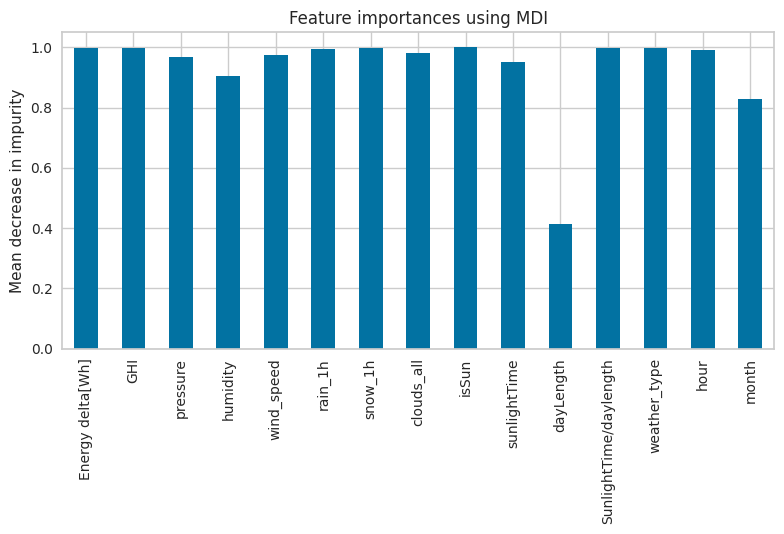

In [27]:
importances = pd.Series(tree.feature_importances_, index=train_X.columns)
importances = 1 - importances
fig, ax = plt.subplots()
importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()


In [ ]:
fig, ax = plt.subplots(figsize = (14, 10))
plot_tree(tree)
plt.show()

In [18]:
tree_scores = cross_val_score(DecisionTreeRegressor(max_leaf_nodes = 1484, 
                                                    max_features = 14), 
                              X, y, cv = 5, n_jobs = 4)

TypeError: DecisionTreeRegressor.__init__() got an unexpected keyword argument 'max_featurrs'

In [ ]:
print(f'Decision Tree scores = {tree_scores}')
print(f'Mean score = {tree_scores.mean()}')
print(f'SD score = {tree_scores.std()}')

In [ ]:
tree_grid_param = {'max_leaf_nodes': [954, 1354, 1654], 
                   'max_features': [10, 12, 13, 14],
                   'criterion': ['squared_error', 'absolute_error']
                  } 


grid_tree = GridSearchCV(DecisionTreeRegressor(), tree_grid_param, cv = 5, n_jobs = 4)

grid_tree.fit(train_X, train_y)

In [ ]:
print(f"Gridge Decision Tree train r2 score = {grid_tree.score(train_X, train_y)}")
print(f"Gridge Decision Tree test r2 score = {grid_tree.score(test_X, test_y)}")

In [ ]:
print(f"Best parameter for Decision Tree = {grid_tree.best_estimator_}")

In [ ]:
forest = RandomForestRegressor(random_state = 42, 
                               n_estimators = 154, 
                               max_leaf_nodes = 704, 
                               n_jobs = 2 
                              )

forest.fit(train_X, train_y)

In [ ]:
print(f"Random forest train r2 score = {forest.score(train_X, train_y)}")
print(f"Random forest test r2 score = {forest.score(test_X, test_y)}")

In [ ]:
permutation = PermutationImportance(forest, random_state = 1).fit(test_X, test_y)
eli5.show_weights(permutation, feature_names = test_X.columns.tolist())

In [ ]:
forest_scores = cross_val_score(RandomForestRegressor(random_state = 42, 
                                                      n_estimators = 154, 
                                                      max_leaf_nodes = 704
                                                     ), 
                                X, y, cv = 5, n_jobs = 4
                               )

In [ ]:
print(f"Cross val scores for random forest = {forest_scores}")
print(f"Mean cross val scores = {forest_scores.mean()}")
print(f"Cross val scores standard deviation = {forest_scores.std()}")

In [ ]:
histboost = HistGradientBoostingRegressor(random_state = 42, 
                                          learning_rate = 0.11, 
                                          max_leaf_nodes = 38, 
                                          scoring = "r2"
                                         )

histboost.fit(train_X, train_y)

In [ ]:
print(f"Histogram Gradient Boosting train r2 score = {histboost.score(train_X, train_y)}")
print(f"Histogram Gradient Boosting test r2 score = {histboost.score(test_X, test_y)}")

In [ ]:
histboost_scores = cross_val_score(HistGradientBoostingRegressor(random_state = 42, 
                                                                 learning_rate = 0.11, 
                                                                 max_leaf_nodes = 38, 
                                                                 scoring = "r2"
                                                                ),
                                   X, y, cv = 5, n_jobs = 4
                                  )

In [ ]:
print(f"Cross val scores for Histogram Gradient Boosting = {histboost_scores}")
print(f"Mean cross val scores = {histboost_scores.mean()}")
print(f"Cross val scores standard deviation = {histboost_scores.std()}")

In [ ]:
lgbr_X = X.copy()

lgbr_X = lgbr_X.rename(columns = lambda x: re.sub('[^A-Za-z0-9_]+', '', x))

lgbr_train_X, lgbr_test_X, lgbr_train_y, lgbr_test_y = train_test_split(lgbr_X, y, 
                                                                        random_state = 42, 
                                                                        test_size = 0.6
                                                                       ) 

In [ ]:
lgbmr = LGBMRegressor(n_estimators = 674,
                      max_depth = 21, 
                      learning_rate = 0.12, 
                      num_leaves = 32 
                     )

lgbmr.fit(lgbr_train_X, lgbr_train_y)

In [ ]:
print(f"LGBM train r2 score = {lgbmr.score(lgbr_train_X, lgbr_train_y)}")
print(f"LGBM test r2 score = {lgbmr.score(lgbr_test_X, lgbr_test_y)}")

In [ ]:
lgbmr_scores = cross_val_score(LGBMRegressor(n_estimators = 674,
                                             max_depth = 21, 
                                             learning_rate = 0.12, 
                                             num_leaves = 32 
                                            ), 
                               lgbr_X, y,
                               cv = 5,
                               n_jobs = 4
                              )

In [ ]:
print(f"LGBM scores = {lgbmr_scores}")
print(f"LGBM mean score = {lgbmr_scores.mean()}")
print(f"LGBM score standard deviation = {lgbmr_scores.std()}")

In [ ]:
xgbr = Pipeline([
         ('scaler', StandardScaler()),
         ('xgbr', XGBRegressor(random_state = 1,
                               n_estimators = 200, 
                               learning_rate = 0.1,
                               base_score = 0.5
                              )
         ) 
        ])

xgbr.fit(train_X, train_y)

In [ ]:
print(f"XGBoost train r2 score = {xgbr.score(train_X, train_y)}")
print(f"XGBoost test r2 score = {xgbr.score(test_X, test_y)}")

In [ ]:
xgbr_scores = cross_val_score(
                Pipeline([
                    ('scaler', StandardScaler()),
                    ('xgbr', XGBRegressor(random_state = 1,
                                          n_estimators = 200, 
                                          learning_rate = 0.1,
                                          base_score = 0.5
                                         ))
                ]), X, y, cv = 5, n_jobs = 2
              )

In [ ]:
print(f"Cross val scores for XGBoost = {xgbr_scores}")
print(f"Mean cross val scores = {xgbr_scores.mean()}")
print(f"Cross val scores standard deviation = {xgbr_scores.std()}")

In [ ]:
scaler = StandardScaler().fit(train_X)

train_X_scaled = scaler.transform(train_X)
test_X_scaled = scaler.transform(test_X)

In [ ]:
neural_net = tf.keras.Sequential([
                layers.Dense(128, input_shape = [train_X_scaled.shape[1]], activation = 'relu'),
                layers.Dense(16, activation = 'relu'),
                layers.Dense(8),
                layers.Dense(1)
             ])

In [ ]:
neural_net.compile(optimizer = 'adam',
                   loss = 'mse',
                   metrics = ['mean_absolute_error']
                  )

In [ ]:
history = neural_net.fit(train_X_scaled, 
                         train_y, 
                         validation_data = (test_X_scaled, test_y),
                         epochs = 14
                        )

In [ ]:
history_df = pd.DataFrame(history.history)

display(history_df.head())

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (10, 5))

sns.lineplot(history_df.loc[:, ['loss', 'val_loss']], 
             ax = axes[0], 
             palette = ['Blue', 'Green']
            ).set(title = "Tensorflow Regression Loss")

sns.lineplot(history_df.loc[:, ['mean_absolute_error', 'val_mean_absolute_error']], 
             ax = axes[1], 
             palette = ['DarkBlue', 'DarkGreen']
            ).set(title = "Tensorflow MAE")

plt.show()

In [ ]:
predict_train_y = neural_net.predict(train_X_scaled) 
predict_y = neural_net.predict(test_X_scaled)

In [ ]:
print(f"Neural Network train r2 score = {r2_score(predict_train_y, train_y)}")
print(f"Neural Network test r2 score = {r2_score(predict_y, test_y)}")

In [ ]:
nn_X = X.copy()

nn_X = pd.DataFrame(preprocessor.fit_transform(nn_X))

In [ ]:
early_stopping = callbacks.EarlyStopping(patience = 5)

In [ ]:
model = tf.keras.Sequential([
                layers.Dense(256, input_shape = [nn_X.shape[1]], activation = 'relu'),
                layers.Dense(128, activation = 'relu'),
                layers.Dense(64, activation = 'relu'),
                layers.Dense(64, activation = 'relu'),
                layers.Dense(16),
                layers.Dense(1)
        ])

model.compile(optimizer = 'adam', loss = 'mse', metrics = ['mae'])

scikeras_model = KerasRegressor(model, 
                                callbacks = [early_stopping], 
                                epochs = 424, 
                                batch_size = 64,
                                verbose = 0
                               )

nn_X_train, nn_X_test, nn_y_train, nn_y_test = train_test_split(nn_X, y, 
                                                                random_state = 1, 
                                                                test_size= 0.6
                                                               )

hist = scikeras_model.fit(nn_X_train, nn_y_train)

nn_y_tr_pred = scikeras_model.predict(nn_X_train)
nn_y_ts_pred = scikeras_model.predict(nn_X_test)

print(f"Neural Network train r2 score = {r2_score(nn_y_tr_pred, nn_y_train)}")
print(f"Neural Network test r2 score = {r2_score(nn_y_ts_pred, nn_y_test)}")

In [ ]:
filename = "neural_network_98and96"

model.save(f"/kaggle/working/{filename}")

In [ ]:
saved_model = tf.keras.models.load_model(f"/kaggle/working/{filename}")

saved_pred = saved_model.predict(nn_X_test)

print(f"Score = {r2_score(saved_pred, nn_y_test)}")

In [ ]:
model = tf.keras.Sequential([
                layers.Dense(64, input_shape = [nn_X.shape[1]], activation = 'relu'),
                layers.Dense(16, activation = 'relu'),
                layers.Dense(8),
                layers.Dense(1)
        ])

model.compile(optimizer = 'adam', loss = 'mse', metrics = ['mae'])

In [ ]:
scikeras_model = KerasRegressor(model, 
                                callbacks = [early_stopping], 
                                epochs = 54, 
                                batch_size = 16,
                                verbose = 0
                               )

In [ ]:
neural_net_scores = cross_val_score(scikeras_model, 
                                    nn_X, y, 
                                    cv = 4, n_jobs = 4
                                   )

In [ ]:
print(f"Cross val scores for Neural Network = {neural_net_scores}")
print(f"Mean cross val scores = {neural_net_scores.mean()}")
print(f"Cross val scores standard deviation = {neural_net_scores.std()}")

In [ ]:
X_transformed = pd.DataFrame(preprocessor.fit_transform(X))

In [ ]:
X_transformed.columns = numeric_X_features + [f'weather_type{i}' for i in range(1, 6)]

In [ ]:
pca = PCA(n_components = 2)
pca.fit(X_transformed)

In [ ]:
X_pca = pca.transform(X_transformed)
print("Original shape: ", X_transformed.shape)
print("Transformed shape: ", X_pca.shape)

In [ ]:
plt.matshow(pca.components_, cmap = 'viridis')
plt.yticks([0, 1], ["First component", "Second component"])
plt.colorbar()
plt.xticks(range(len(X_transformed.columns)), X_transformed.columns, rotation = 60, ha = 'left')
plt.show()

In [ ]:
# print best features by name and by most important to least important
print(f"Best features by name: {X_transformed.columns[np.argsort(pca.components_[0])][::-1]}\n")
print(f"Best features by importance: {np.sort(pca.components_[0])[::-1]}\n")

In [ ]:
plt.figure(figsize = (8, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c = y, cmap = 'viridis')
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.show()

In [ ]:
viz = ValidationCurve(
        RandomForestRegressor(random_state = 1), 
        param_name = "max_leaf_nodes",
        param_range = [10**x + 1 for x in range(1, 5)], 
        cv = 4, scoring = "r2",
        logx = True,
        n_jobs = 4
      )

In [ ]:
viz.fit(X, y)